# Largest Rectangle under a histogram

Problem description: https://leetcode.com/problems/largest-rectangle-in-histogram/

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
tests = (
    ([2, 1, 5, 6, 2, 3], 10),
    ([6, 3, 1, 4, 12, 4], 12),
    ([5, 6, 7, 4, 1], 16),
    ([2, 1, 3, 4, 1], 6),
)

Which look like:

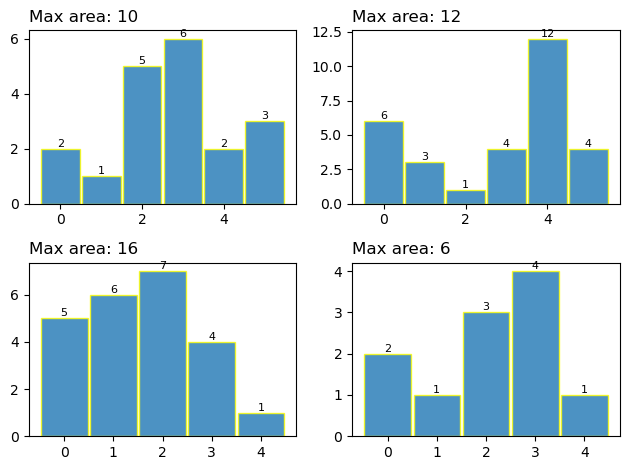

In [54]:
# code-fold: true
fig, axes = plt.subplots(2, 2, layout="tight")
for ax, (arr, ans) in zip(axes.flatten(), tests):
    bar = ax.bar(
        range(len(arr)),
        arr,
        width=0.95,
        alpha=0.8,
        edgecolor="yellow",
    )
    ax.set_title(f"Max area: {ans}", loc="left")
    ax.bar_label(bar, fontsize=8)

## A simple solution


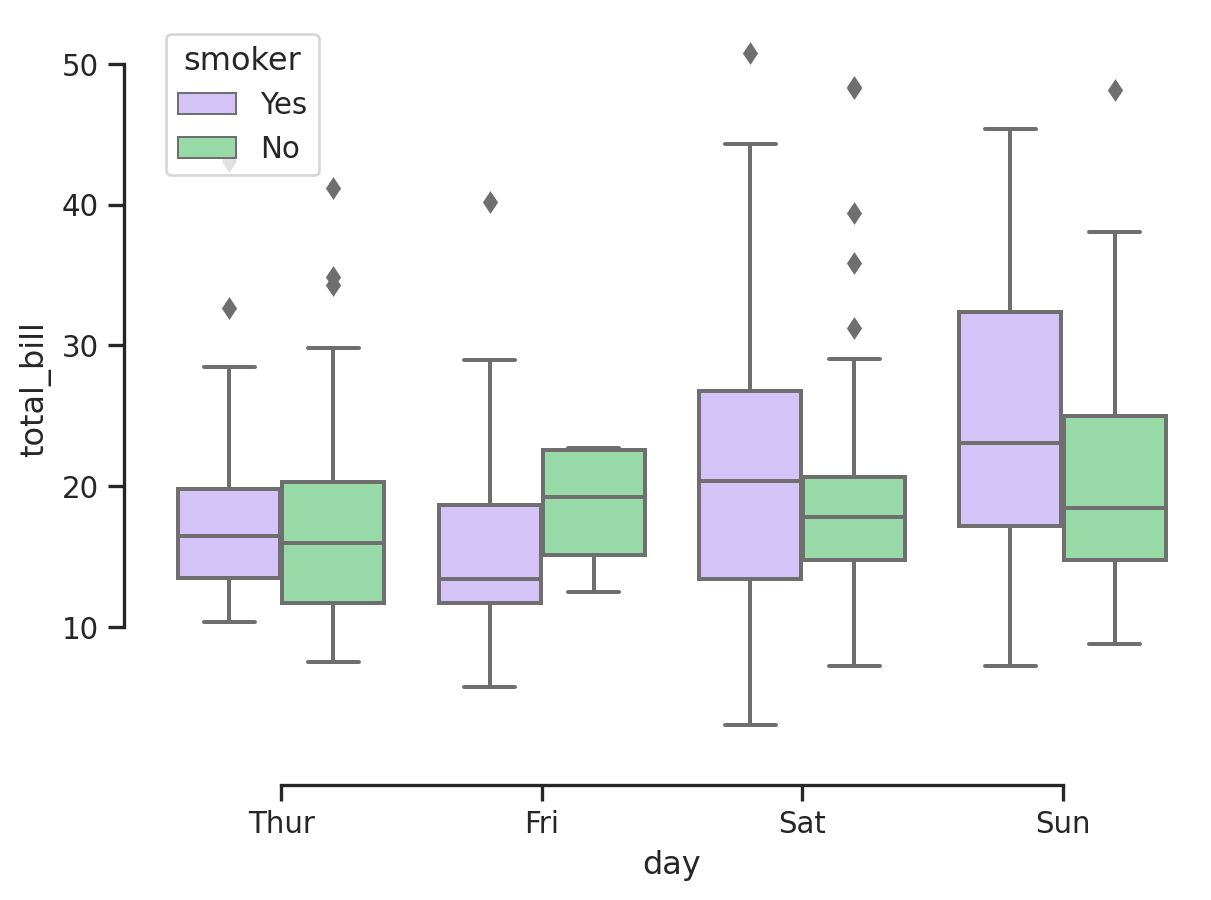

In [2]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)
sns.despine(offset=10, trim=True)

## Using stacks



In [18]:
def HistogramArea(arr):
    stack = [-1]
    max_area = 0
    for i in range(len(arr)):
        while stack[-1] != -1 and arr[stack[-1]] >= arr[i]:
            current_height = arr[stack.pop()]
            current_width = i - stack[-1] - 1
            max_area = max(max_area, current_height * current_width)
        stack.append(i)
 
    while stack[-1] != -1:
        current_height = arr[stack.pop()]
        current_width = len(arr) - stack[-1] - 1
        max_area = max(max_area, current_height * current_width)
    return max_area

for arr, ans in tests:
    assert HistogramArea(arr) == ans
    print(f"{arr} ----> {ans}")

[2, 1, 5, 6, 2, 3] ----> 10
[6, 3, 1, 4, 12, 4] ----> 12
[5, 6, 7, 4, 1] ----> 16
[2, 1, 3, 4, 1] ----> 6


<Axes: >

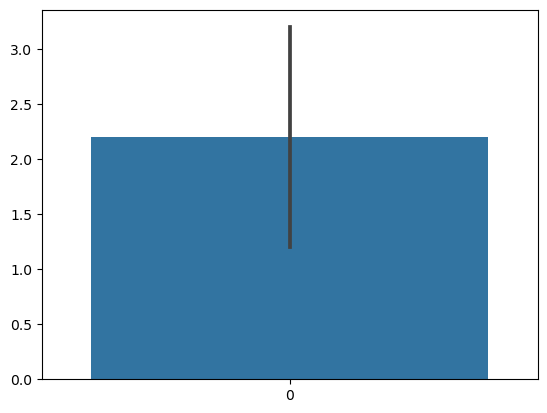

In [20]:
sns.barplot(arr)

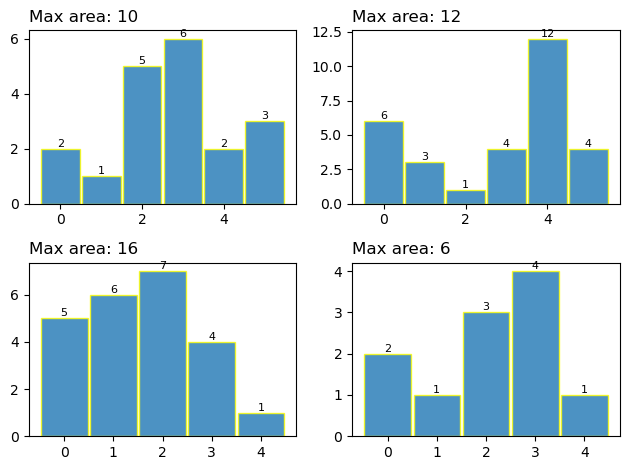